## Import Modules

In [1]:
import os
import pathlib
import random

# Data Science modules
import numpy as np
import pandas as pd
import torch as torch

# Modules for data loading
from dataset import Dataset

# Modules for data augmentation
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Modules for model training
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

# Modules for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from plot import plot_img_bbox

## Loading Data

In [2]:
# Creating Data Transformer for Training and Validation
def train_transform():
    return A.Compose([A.HorizontalFlip(0.5),
                      A.VerticalFlip(0.3),
                      ToTensorV2(p=1.0)],
                     bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Creating Data Transformer for Testing
def test_transform():
    return A.Compose([ToTensorV2(p=1.0)],
                     bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [3]:
# Image Directory
img_dir = 'data/'

# Data Groups
grps = ["train", "test"]

# Train and Test Data
train_dir = 'data/train'
dataset = Dataset(train_dir, 224, 224, transforms=train_transform())
print('Images in train dataset =', len(dataset))

test_dir = 'data/test'
test_dataset = Dataset(test_dir, 224, 224, transforms=test_transform())
print('Images in test dataset =', len(test_dataset))

Images in train dataset = 240
Images in test dataset = 60


## Visualize the data

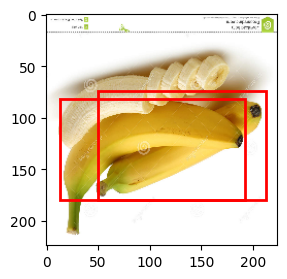

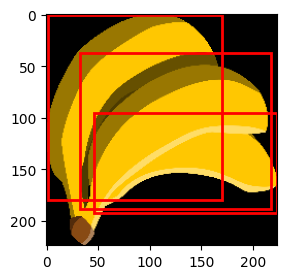

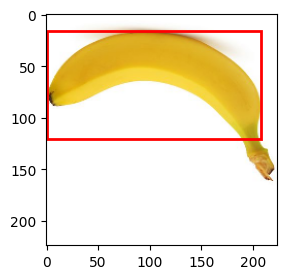

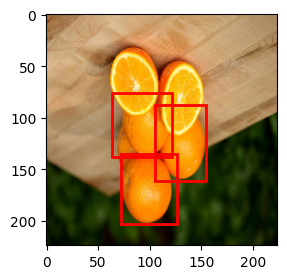

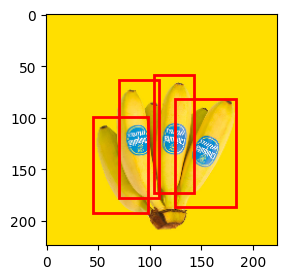

In [4]:
# Selecting some random images from the train dataset
random_images = [dataset[i] for i in random.sample(range(0, len(dataset)), 5)]
for img, target in random_images:
    plot_img_bbox(img, target)

## Data Preprocessing 
**Model** : Faster R-CNN model with a ResNet-50-FPN backbone 

**Reference** : https://arxiv.org/abs/1506.01497

In [6]:
# Sets the seed for generating random numbers
torch.manual_seed(42)
np.random.seed(42)

# Randomly shuffle the training data
indices = np.random.permutation(len(dataset)).tolist()

In [7]:
# Split the dataset into training and validation - 80% training, 20% validation
test_split = 0.2
tsize = len(dataset) - int(len(dataset)*test_split)

train_dataset = torch.utils.data.Subset(dataset, indices[:tsize])
print('Images in train dataset =', len(train_dataset))
val_dataset = torch.utils.data.Subset(dataset, indices[tsize:])
print('Images in validation dataset =', len(val_dataset))

Images in train dataset = 192
Images in validation dataset = 48


{'boxes': tensor([[ 87.4039,  46.5569, 185.7882, 152.8471]]), 'labels': tensor([3]), 'area': tensor([10457.2881]), 'iscrowd': tensor([0]), 'image_id': tensor([226])}


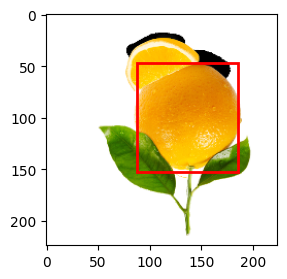

In [8]:
# collate_fn receives a list of tuples if your __getitem__ function from a Dataset subclass returns a tuple, 
# or just a normal list if your Dataset subclass returns only one element
def collate_fn(batch):
    return tuple(zip(*batch))

# Data Loaders for Training, Validation and Testing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Number of training and testing batches
n_batches, n_batches_test = len(train_loader), len(test_loader)

# Visualize a batch of training data
images, targets = next(iter(train_loader))
print(targets[0])
plot_img_bbox(images[0], targets[0])